<a href="https://colab.research.google.com/github/nimmitahsin1727/breast-cancer-classification/blob/main/Breast_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Breast Cancer Classification with VGG16, InceptionV3 and ResNet.**

**Run the code cell below** to mount google drive.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


**Run the code cell below** to import the needed libraries.

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import json
import os
from os import listdir
import cv2
from PIL import Image
import seaborn as sns
sns.set()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## For getting the local py files
## Only for CoLab execution
# Start

import sys 
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/breast_cancer/')

ResNET = !cp r"/content/gdrive/MyDrive/Colab Notebooks/breast_cancer/ResNET.py"
helper_functions = !cp r"/content/gdrive/MyDrive/Colab Notebooks/breast_cancer/helper_functions.py"

# End

## ResNET Implementation and some helper function.
from ResNET import Block, ResNET
from helper_functions import to_categorical, calculate_accuracy, prepare_data_for_resnet


**Run the code cell below** to intialize all the variables.

In [ ]:
base_path = "/content/gdrive/MyDrive/Colab Notebooks/breast_cancer"
dataset_path = base_path + "/dataset/"
target_size = (224,224)
batch_size = 64

# ResNET
path = '/content/gdrive/MyDrive/Colab Notebooks/breast_cancer/dataset/**/*.png'
data_size = 2000    ## For ResNet data size.
ResNET_model_path = base_path + '/ResNET/resNET_model.pth'

# VGG16
vgg16_model_path = base_path + "/vgg16/VGG16_model.h5"
vgg16_model_plot_path = base_path + "/vgg16/vgg16_model.png"
vgg16_model_history_path = base_path + "/vgg16/vgg16_history.json"

# InceptionV3
inceptionv3_path = base_path + "/inceptionv3/"
inceptionv3_model_path = base_path + "/inceptionv3/inceptionv3_model.h5"
inceptionv3_plot_path = base_path + "/inceptionv3/inceptionv3_model.png"

# **Load Dataset and Preprocess Data**
Creating root dataframe with all data including the information of their patient id, image path and target.

In [ ]:
folder = listdir(dataset_path)

total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = dataset_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

In [ ]:
k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = dataset_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

,patient_id,path,target
0,10253,/content/gdrive/MyDrive/Colab Notebooks/breast...,0
1,10253,/content/gdrive/MyDrive/Colab Notebooks/breast...,0
2,10253,/content/gdrive/MyDrive/Colab Notebooks/breast...,0
3,10253,/content/gdrive/MyDrive/Colab Notebooks/breast...,0
4,10253,/content/gdrive/MyDrive/Colab Notebooks/breast...,0


First create non_cancer_data & cancer_data. Then, merged them in sliced_data.

In [ ]:
non_cancer_data = data.query("target == 0").head(2000)
print(non_cancer_data['target'].value_counts())
cancer_data = data.query("target == 1").head(2000)
print(cancer_data['target'].value_counts())
sliced_data = pd.concat([non_cancer_data,cancer_data])
print(sliced_data['target'].value_counts())

0    2000
Name: target, dtype: int64
1    2000
Name: target, dtype: int64
0    2000
1    2000
Name: target, dtype: int64


In [ ]:
sliced_data.target.unique()

array([0, 1], dtype=object)

In [ ]:
sliced_data.shape

(4000, 3)

In [ ]:
sliced_data.head()
sliced_data.loc[:, "target"] = data.target.astype(np.str)
sliced_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 9253
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  4000 non-null   object
 1   path        4000 non-null   object
 2   target      4000 non-null   object
dtypes: object(3)
memory usage: 125.0+ KB


In [ ]:
unique_paths = sliced_data.path.unique()

**Dataset splitting**

VGG16 & InceptionV3

In [ ]:
sub_train_ids, test_ids = train_test_split(unique_paths,
                                           test_size=0.2,
                                           random_state=0)
train_ids, valid_ids = train_test_split(sub_train_ids, test_size=0.1, random_state=0)

ResNET

In [ ]:
train_loader, valid_loader, test_loader = prepare_data_for_resnet(path, data_size, batch_size)

In [ ]:
print(f"Now, we're taking {round(len(train_ids)/unique_paths.shape[0]*100, 1)}% for training, {round(len(valid_ids)/unique_paths.shape[0]*100,1)}% for validation, {round(len(test_ids)/unique_paths.shape[0]*100,1)}% for testing")

Now, we're taking 72.0% for training, 8.0% for validation, 20.0% for testing


In [ ]:
print(f'{len(train_ids)}, {len(valid_ids)}, {len(test_ids)}')

2880, 320, 800


In [ ]:
train_df = sliced_data.loc[sliced_data.path.isin(train_ids),:].copy()
test_df = sliced_data.loc[sliced_data.path.isin(test_ids),:].copy()
valid_df = sliced_data.loc[sliced_data.path.isin(valid_ids),:].copy()

print(f"train set shape: {train_df.shape}")
print(f"test set shape: {test_df.shape}")
print(f"validation set shape: {valid_df.shape}")

train set shape: (2880, 3)
test set shape: (800, 3)
validation set shape: (320, 3)


Reseting index for each dataset. Because, we're creating three dataset by slicing the root dataframe. After slicing it, each dataset's index will be scattered and will have the index of root dataframe.

In [ ]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

Creating image data generator for each dataset.

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_batches = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

valid_batches = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

test_batches = test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'path', 
    y_col ='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
)

Found 2880 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


### **Target distributions** 
Let's take a look at the target distribution difference of the datasets:

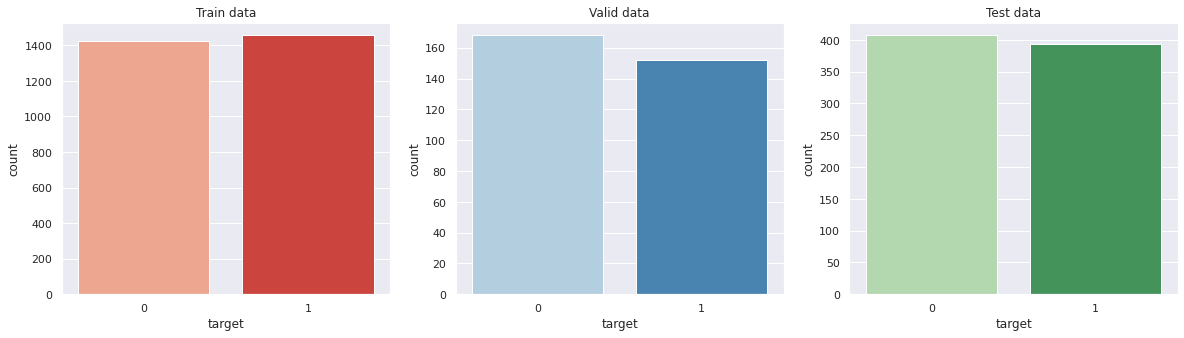

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(train_df.target, ax=ax[0], palette="Reds")
ax[0].set_title("Train data")
sns.countplot(valid_df.target, ax=ax[1], palette="Blues")
ax[1].set_title("Valid data")
sns.countplot(test_df.target, ax=ax[2], palette="Greens");
ax[2].set_title("Test data");

# **VGG16**

### **Model Creation**

The following functions will be useful to create a VGG16 model. The function  `create_vgg16_model` will create/load a VGG16 model.


**Run the code cell below** to create a model. 

In [ ]:
def create_vgg16_model(model_path=None):
    """breif description.
    
    Arguments
    ---------
    model_path : String
      String containing the path of a model.
    
    Returns
    ---------
    vgg_model: keras.engine.functional.Functional
      Model containing .... 
    """
    if model_path:
        return tf.keras.models.load_model(model_path)
    else:
        """ Load VGG model with imagenet trained weights and pass our input shape . """
        base_model = tf.keras.applications.vgg16.VGG16(
            weights='imagenet', # Load weights pre-trained on ImageNet.
            input_shape=(224, 224, 3),
        )
        
        """ Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights. """
        for layer in base_model.layers:
            layer.trainable = False
        
        """ Add all layers to model except the output layer. """
        new_model = keras.models.Sequential()
        new_model._name="VGG16"
        
        for layer in base_model.layers[0:-1]:
            new_model.add(layer)
            
        """ Add all layers to model except the output layer. """
        new_model.add(layers.Dense(1, activation="sigmoid", name='output'))
        
        return new_model
        
vgg_model = create_vgg16_model(vgg16_model_path)

### **Model Summary**

**Run the code cell below** to create a summary of our model. 

In [ ]:
print(type(vgg_model))
vgg_model.summary()

<class 'keras.engine.sequential.Sequential'>
Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (C

### **Model Plotting**
**Run the code cell below** to create a plot of a model and download it. 

*Make sure you have installed `pydot` & `graphviz` for plot_model.*

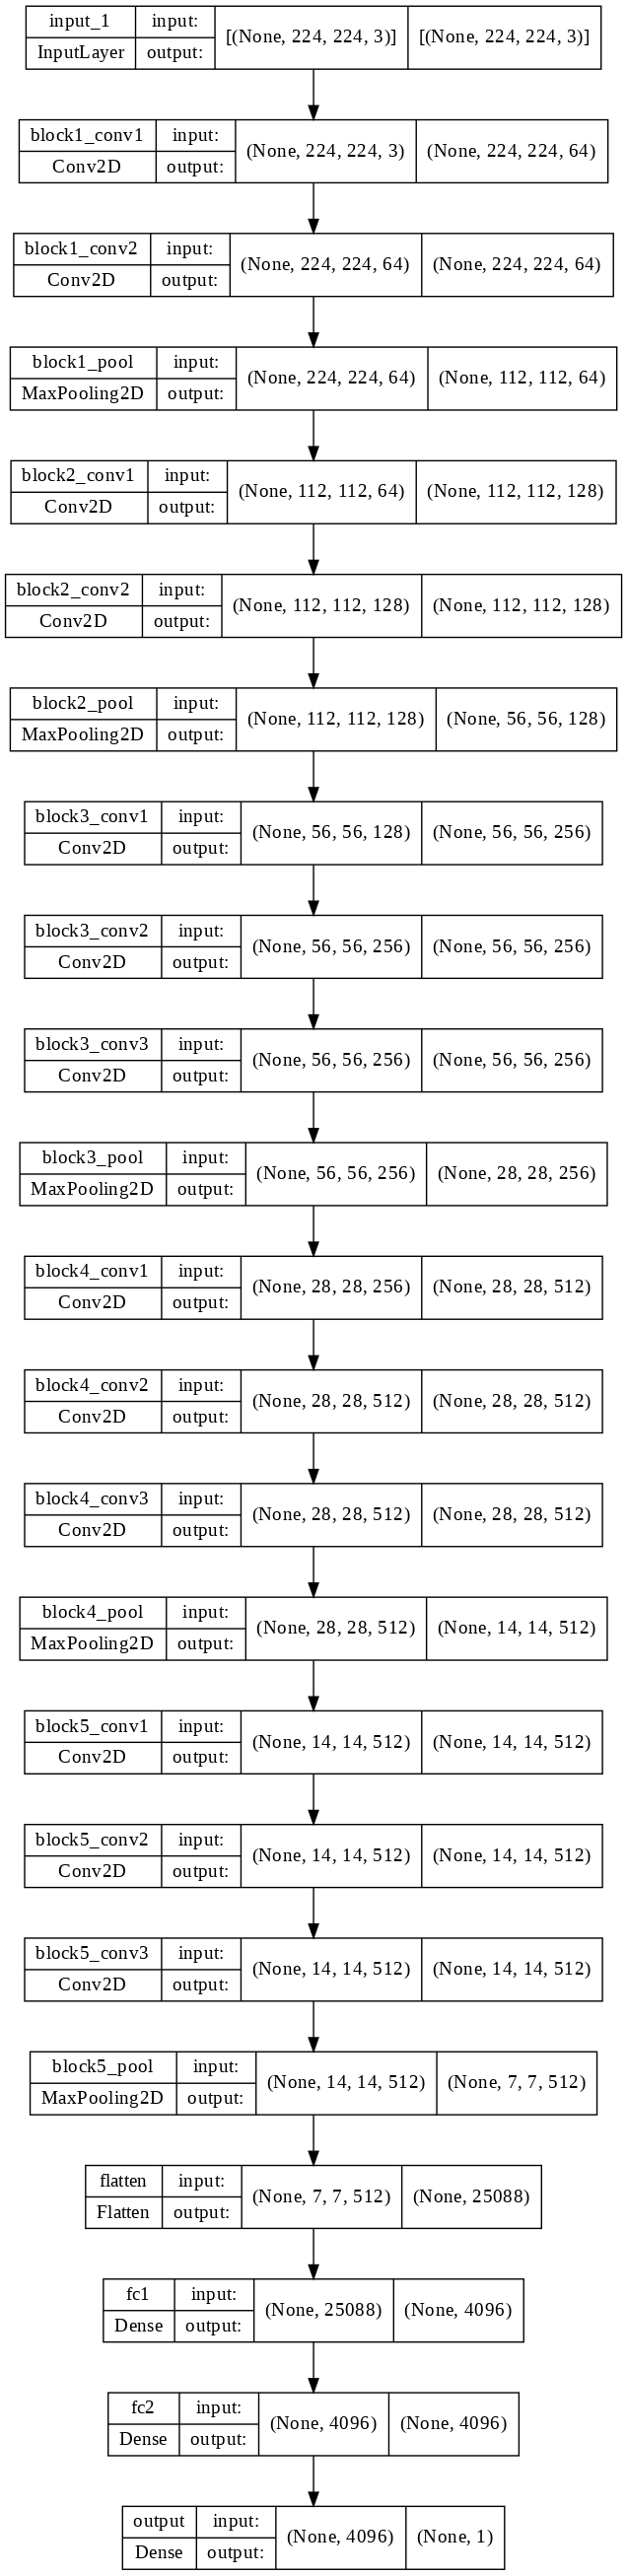

In [ ]:
plot_model(vgg_model, to_file=vgg16_model_plot_path, show_shapes=True, dpi=100)

### **Training**

**Compile the model with necessary configs:**

* Here I will be using **Adam** optimiser to reach to the global minima while training out model. If I am stuck in local minima while training then the adam optimiser will help us to get out of local minima and reach global minima. We will also specify the **learning rate** of the optimiser, here in this case it is set at **0.001**. If our training is bouncing a lot on epochs then we need to decrease the learning rate so that we can reach global minima.

* **binary_crossentropy** function computes the cross-entropy loss between true labels and predicted labels.

* And metrics will be **accuracy**.


**Train the model with callbacks function:**

* **ModelCheckpoint** - It helps us to save the model by monitoring a specific parameter of the model. In this case I am monitoring validation accuracy by passing `val_accuracy` to ModelCheckpoint. The model will only be saved to disk if the validation accuracy of the model in current epoch is greater than what it was in the last epoch.

* **EarlyStopping** - It helps us to stop the training of the model early if there is no increase in the parameter which I have set to monitor in EarlyStopping. In this case I am monitoring validation accuracy by passing `val_accuracy` to EarlyStopping. I have here set patience to `5` which means that the model will stop to train if it doesn’t see any rise in validation accuracy in 5 epochs.

**Model fitting:**

Here, I will pass training and validation data, `epochs` is set to 100, `callbacks` and `verbose` is 2. 



***If you don't want to train the model, you can skip this cell.***

In [ ]:
def vgg_training(model):
  # model compile
  model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate= 0.0001), metrics=['accuracy'])

  # callbacks funstions
  model_checkpoints = tf.keras.callbacks.ModelCheckpoint(
      "Breast_Cancer_VGG16_model.weights.best.h5", 
      save_best_only=True, 
      verbose=1, 
      mode='max', 
      monitor='val_accuracy'
  )
  early_stopping = keras.callbacks.EarlyStopping(
      monitor="val_accuracy",
      mode="max",
      patience=5,
      verbose=1
  )
  callbacks = [
      model_checkpoints,
      early_stopping
  ]

  # model fitting
  vgg_history = model.fit(
      train_batches, 
      validation_data=valid_batches, 
      epochs=100,
      callbacks=callbacks, 
      verbose=2
  )

  # Store training history
  with open(vgg16_model_history_path, 'w') as file:
      json.dump(vgg_history.history, file)
  
  # Save model
  vgg_model.save(vgg16_model_path)

vgg_training(vgg_model)

**Retrive training history**

Loading history from a JSON file.

In [ ]:
with open(vgg16_model_history_path) as file:
    vgg_history_data = json.load(file)

**Plot the training and validation outcome**

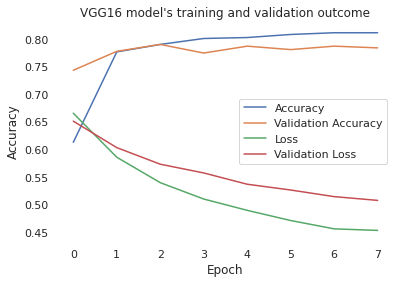

In [ ]:
plt.plot(vgg_history_data["accuracy"])
plt.plot(vgg_history_data['val_accuracy'])
plt.plot(vgg_history_data['loss'])
plt.plot(vgg_history_data['val_loss'])
plt.title("VGG16 model's training and validation outcome")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.show()

### **Evalutaion**

Evaluate model on test data.

In [ ]:
vgg_model_loss, vgg_model_accuracy = vgg_model.evaluate(test_batches, verbose=2)
print("Accuracy: {:5.2f}%".format(100 * vgg_model_accuracy))
print("Loss: {:5.2f}%".format(100 * vgg_model_loss))

13/13 - 417s - loss: 0.5580 - accuracy: 0.7250 - 417s/epoch - 32s/step
Accuracy: 72.50%
Loss: 55.80%


### **Confusion Matrix**

It visualizes and summarizes the performance of a classification algorithm.

*0 -> Non-IDC*

*1 -> IDC*

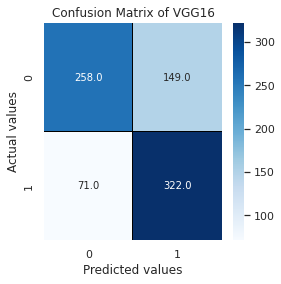

In [ ]:
Y_pred_vgg = vgg_model.predict_generator(test_batches, test_df.shape[0] // batch_size+1)
y_pred_vgg = np.where(Y_pred_vgg >= 0.5, 1, 0).flatten()
vgg_cm = confusion_matrix(test_batches.classes, y_pred_vgg)
f,ax = plt.subplots(figsize=(4, 4))
sns.heatmap(vgg_cm, annot=True, linewidths=0.01, cmap="Blues", linecolor="black", fmt='.1f', ax=ax)
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.title("Confusion Matrix of VGG16")
plt.show()

### **Classification Report**

Here, we will have a performance evaluation metric where we can find **precision**, **recall**, **F1 Score**, and **support** of our trained model.

*0 -> Non-IDC*

*1 -> IDC*

In [ ]:
print(classification_report(test_batches.classes, y_pred_vgg, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.78      0.63      0.70       407
           1       0.68      0.82      0.75       393

    accuracy                           0.73       800
   macro avg       0.73      0.73      0.72       800
weighted avg       0.73      0.72      0.72       800



### **Prediction**

Load one Non-IDC and IDC picture, do prediction on our trained model.

*0 -> Non-IDC*

*1 -> IDC*

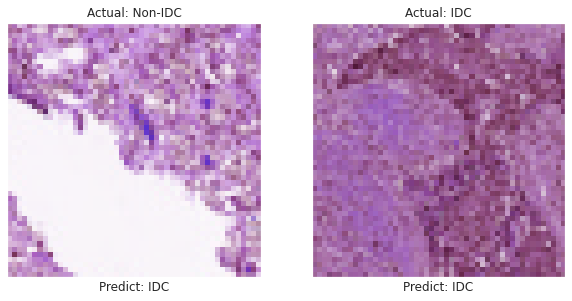

In [ ]:
def prediction_for_vgg16(dataframe):
    plt.figure(figsize=(10,10))
    
    for i, v in enumerate([0, 799]):
        plt.subplot(1,2,i+1)
        image = cv2.imread(dataframe.loc[v, "path"])

        # create input data
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((224, 224))
        expand_input = np.expand_dims(resize_image, axis=0)
        input_data = np.array(expand_input)
        input_data = input_data/255

        # prediction
        prediction = vgg_model.predict(input_data)

        # plot the image
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=plt.cm.binary)
        plt.title("Actual: %s" % ("Non-IDC" if int(dataframe.loc[v, "target"]) == 0 else "IDC") )
        plt.xlabel("Predict: %s" % ("IDC" if prediction >= 0.5 else "Non-IDC"))
        
    plt.show()

prediction_for_vgg16(test_df)

# **InveptionV3**

### Model Implementation

***If you don't want to train the model, you can skip this cell.***

In [ ]:
def InceptionV3(base_model):
    """Explanation:
    
    Arguments
    ---------
    base_model :
    tf.keras.applications.InceptionV3
    --------
    save_model_path : containing the path where to save the model.
    
    Returns
    ---------
    InceptionV3_model: keras.engine.functional.Functional
    -------------
    """ 
    """ Creating Model """

    base_model = base_model
    
    # Freezing Layers  
    """..Freezing the layers and making it non-training except the last three layers.."""
    for layer in base_model.layers[:-3]:
        
        layer.trainable=False 

    """ ...Building Inception Model...."""
    InceptionV3_model=keras.models.Sequential() # Making it sequential 
    InceptionV3_model.add(base_model) # Adding the base_model to the sequencial model

    """Adding the Droupout and Flatten Layers"""
    InceptionV3_model.add(layers.Dropout(0.5))
    InceptionV3_model.add(layers.Flatten())

    """Adding Dense layer and sigmoid function"""
    InceptionV3_model.add(layers.Dense(1,activation='sigmoid',name='output'))

    return InceptionV3_model

"""Call this function to create inceptionV3 model..."""        
InceptionV3_model = InceptionV3(
    base_model=tf.keras.applications.InceptionV3(input_shape=(224,224,3),
    include_top=False,weights="imagenet")
)

87924736/87910968 [==============================] - 1s 0us/step


**Load model.**


> Load the saved model if you don't want to train the model.



In [ ]:
InceptionV3_model=keras.models.load_model(inceptionv3_model_path)

### Model Summary

In [ ]:
InceptionV3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 output (Dense)              (None, 1)                 51201     
                                                                 
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


### Model Plotting


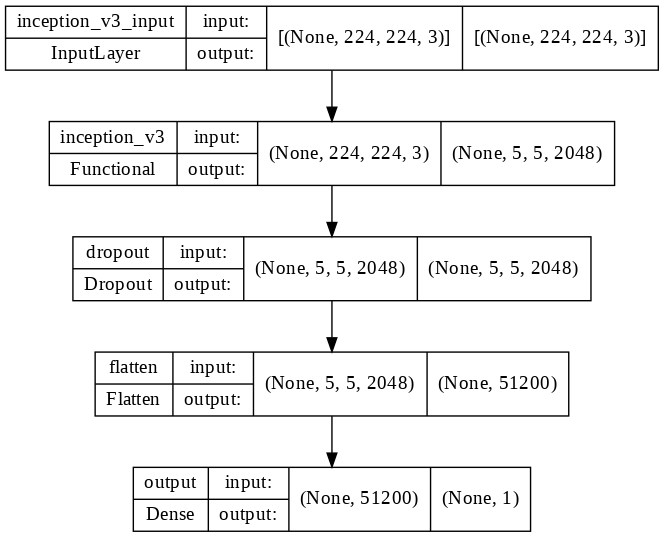

In [ ]:
plot_model(InceptionV3_model, to_file=inceptionv3_plot_path, show_shapes=True, dpi=100)

### Training

***If you don't want to train the model, you can skip this cell.*** We have already saved the model as "inceptionv3_model.h5". You can load it and test the model.

In [ ]:
""" Crompiling the Model """
    
InceptionV3_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate= 0.0001), metrics=['accuracy'])


""" Checkpoints for monitoring validation accuracy by which it helps the model to save when there is no improvement. """"

model_checkpoints = tf.keras.callbacks.ModelCheckpoint("Breast_Cancer_InceptionV3_model.weights.best.h5", save_best_only=True, verbose = 1,  mode='max',  monitor='val_accuracy')

"""" It helps the model to save from under and over fitting. It saves the model there is no improvement anymore to save the model from overfitting."""
early_stopping = keras.callbacks.EarlyStopping( monitor="val_accuracy", mode="max",patience=5,verbose=1)

# Regarding Early Stop and Model Checkpoints as Calssbacks
callbacks = [model_checkpoints,early_stopping]

"""Saving the history of the model.."""
inception_history = InceptionV3_model.fit(train_batches, validation_data = valid_batches, epochs = 100, callbacks = [callbacks], verbose = 1)

#Saving the models
InceptionV3_model.save(inceptionv3_model_path)

Traing graph

***If you don't want to train the model, you can skip this cell.***

In [ ]:
#Loss
plt.plot(inception_history.history['loss'], label='Train Loss')
plt.plot(inception_history.history['val_loss'], label='Validation Loss')
plt.title("InceptionV3 Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.savefig(inceptionv3_path+'LossVal_loss')

#Accuracies
plt.plot(inception_history.history['accuracy'], label='Train Accuracy')
plt.plot(inception_history.history['val_accuracy'], label='Validation Accuracy')
plt.title("InceptionV3 Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.savefig(inceptionv3_path+'AccVal_acc')

### Evalutaion

In [ ]:
def print_test_inceptionV3(test_batches):
    inception_model_loss, inception_model_accuracy = InceptionV3_model.evaluate(test_batches, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * inception_model_accuracy))
    print("Restored model, loss: {:5.2f}%".format(100 * inception_model_loss))
print_test_inceptionV3(test_batches) 

13/13 - 98s - loss: 0.7051 - accuracy: 0.7763 - 98s/epoch - 8s/step
Restored model, accuracy: 77.63%
Restored model, loss: 70.51%


### Confusion Matrix & Classification Report

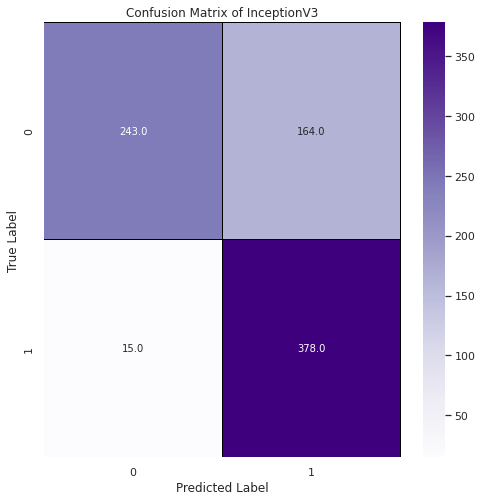

              precision    recall  f1-score   support

           0       0.94      0.60      0.73       407
           1       0.70      0.96      0.81       393

    accuracy                           0.78       800
   macro avg       0.82      0.78      0.77       800
weighted avg       0.82      0.78      0.77       800



In [ ]:
def scores() :
    
    """Plotting the score values : Confusion Matrix, Precision, Recall, f1-score, Accuracy."""
    
    Y_pred_inception = InceptionV3_model.predict_generator(test_batches, test_df.shape[0] // batch_size+1)
    y_pred_inception = np.where(Y_pred_inception > 0.5, 1, 0).flatten()
    
    """Doing prediction for each classes and plotting confusion matrix."""
    
    inception_cm = confusion_matrix(test_batches.classes, y_pred_inception)
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(inception_cm, annot=True, linewidths=0.01,cmap="Purples",linecolor="black", fmt= '.1f',ax=ax)
    
    """Plotting confusion matrix title."""
    
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix of InceptionV3")
    plt.show()
    
    """Plotting score values : Precision, Recall, f1-score"""
    
    print(classification_report(test_batches.classes, y_pred_inception, target_names=['0', '1']))
    
scores()

### **Prediction**

Load one Non-IDC and IDC picture, do prediction on our trained model.

*0 -> Non-IDC*

*1 -> IDC*

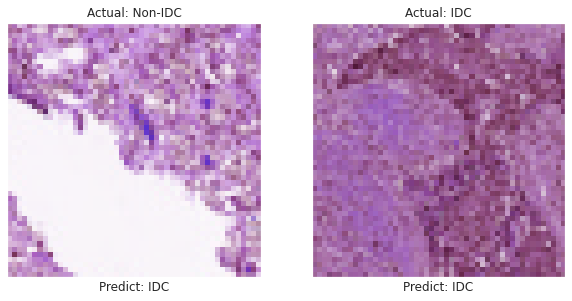

In [ ]:
from PIL import Image
def prediction_for_inceptionv3(dataframe):
    plt.figure(figsize=(10,10))
    
    for i, v in enumerate([0, 799]):
        plt.subplot(1,2,i+1)
        image = cv2.imread(dataframe.loc[v, "path"])

        # create input data
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((224, 224))
        expand_input = np.expand_dims(resize_image, axis=0)
        input_data = np.array(expand_input)
        input_data = input_data/255

        # prediction
        prediction = InceptionV3_model.predict(input_data)

        # plot the image
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=plt.cm.binary)
        plt.title("Actual: %s" % ("Non-IDC" if int(dataframe.loc[v, "target"]) == 0 else "IDC") )
        plt.xlabel("Predict: %s" % ("IDC" if prediction >= 0.5 else "Non-IDC"))
        
    plt.show()

prediction_for_inceptionv3(test_df)

# **ResNET34**

### **Model Creation**

The following portion is used to load the `ResNET` implementation which is in a seperate `.py` file.


**Run the code cell below** to initialize the model. 

#### Initialize Configuration.

In [ ]:
# Configurations

num_epochs = 50
lr = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of available classes and the image channel
num_classes = 2
img_channel = 3

__Assert block__ to check if the implemented Model class return the correct label dim

In [ ]:
def test():
    resnet = ResNET(Block, [3, 4, 6, 3], img_channel, num_classes)
    _x = torch.randn(2, 3, 244, 244)
    _y = resnet(_x).to(device)
    return (_y.shape)
assert test() == (2,2), 'Y is wrong shape!'
print("Correct!")

Correct!


Loading a saved model if you don't wanna train the model

In [ ]:
#/content/gdrive/MyDrive/Colab Notebooks/breast_cancer/ResNET/resNET_model.pth 
n_model = ResNET(Block, [3, 4, 6, 3], img_channel, num_classes)
n_model.load_state_dict(torch.load(ResNET_model_path))

n_model.eval()

# Setting model to the main model for future use.
model = n_model

Checking accuracy on test data set.

In [ ]:
_acc, _pred = calculate_accuracy(n_model, test_loader)

print('Test Accuracy: %.2f%%' % (_acc))

correct_pred:  tensor(27) , num_examples:  30
Test Accuracy: 90.00%


#### Initializing the ResNet Model

In [ ]:
# ResNET Layers [3, 4, 6, 3] for 34 and 50
model = ResNET(Block, [3, 4, 6, 3], img_channel, num_classes)

model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Train the ResNet Model

In [ ]:
start_time = time.time()
minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []

for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)
      
        features = torch.tensor(features, dtype=torch.float32)
        features = torch.transpose(features, 3, 1)#(x, 1, 3)
        targets = torch.tensor(targets, dtype=torch.float32)
      
        logits = model(features)
        cost = loss(logits, targets)
        optimizer.zero_grad()
        cost.backward()

        optimizer.step()
      
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                    %(epoch+1, num_epochs, batch_idx, 
                      len(train_loader), cost))
          
    model = model.eval() # eval mode to prevent upd. batchnorm params during inference
    with torch.set_grad_enabled(False):# save memory during inference
        train_acc, train_pred = calculate_accuracy(model, train_loader)
        valid_acc, valid_pred = calculate_accuracy(model, valid_loader)
        print('Epoch: %03d/%03d training accuracy: %.2f%% | Validation accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              train_acc, valid_acc))
        train_acc_list.append(train_acc.item())
        valid_acc_list.append(valid_acc.item())

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/001 | Batch 000/007 | Cost: 0.6681
correct_pred:  tensor(23) , num_examples:  161
correct_pred:  tensor(0) , num_examples:  11
Epoch: 001/001 training accuracy: 14.29% | Validation accuracy: 0.00%
Time elapsed: 2.28 min
Total Training Time: 2.28 min


In [ ]:
# Saving the model for future use
#torch.save(model.state_dict(), 'resNET_model.pth')

#### Display the accuracy Plot:

In [ ]:
#import matplotlib.pyplot as plt

num_epochs = len(train_acc_list)

plt.plot(np.arange(1, num_epochs+1),
          train_acc_list, label='Training')
plt.plot(np.arange(1, num_epochs+1),
          valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

#### Computing test accuracy and plotting a few examples with their predictions

correct_pred:  tensor(27) , num_examples:  30
Test accuracy: 90.00%


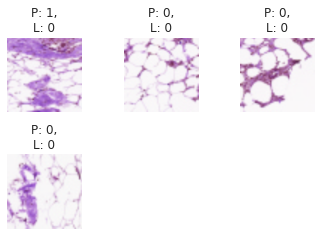

In [ ]:
acc, predictions = calculate_accuracy(model, test_loader)
print('Test accuracy: %.2f%%' % (acc))

#%% Training data visualization
images, labels = next(iter(test_loader))

plt.figure(figsize=(5,5))
for i in range(4):
    
    plt.subplot(3, 3, i+1)
    label = np.argmax( labels[i] ,axis=0)
    
    ## Debugging
    #print(len(label))
    #print(predictions.shape)
    #print(images[i].shape, ' : ', images[i].permute(1, 2, 0).shape)
    #print(predictions[i].item(), '|', label.item())
    
    str = F"P: {predictions[i].item()},\nL: {label.item()}"
    plt.title(str)
    plt.imshow(images[i])
    
    plt.axis('off')

plt.tight_layout()
plt.show()

Generate Confusion Matrix and Classification Report.

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



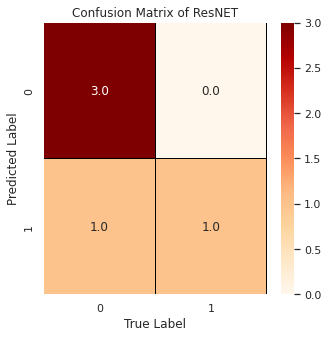

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
sns.set()

def get_predictions_and_labels(data_loader, device = 'cpu'):
    
    labels = None
    logits = None
    
    for batch_idx, (features, targets) in enumerate(data_loader):
        features = torch.tensor(features, dtype=torch.float32)
        features = torch.transpose(features, 3, 1)#(x, 1, 3)
        targets = torch.tensor(targets, dtype=torch.float32)
        
        features = features.to(device)
        targets = targets.to(device)
        
        logits = model(features)
        labels = targets
    
    labels = np.argmax( labels ,axis=1)
    logits = np.argmax( logits.detach().numpy() ,axis=1)
    
    return labels, logits

def get_classification_matrics(data_loader, target_names = ['0', '1'], device = 'cpu'):
    labels, prediction = get_predictions_and_labels(data_loader, device)
    
    print(classification_report(labels, prediction, target_names=target_names))
    
    print_confusion_matrix(labels, prediction, 
                           title = 'Confusion Matrix of ResNET',
                           x_lable = 'Predicted Label',
                           y_lable = 'True Label')
    
def print_confusion_matrix(labels, prediction, title, x_lable, y_lable, fig_size = 5):
    
    resNet_cm = confusion_matrix(labels, prediction)
    f,ax = plt.subplots(figsize=(fig_size, fig_size))
    sns.heatmap(resNet_cm, annot=True, linewidths=0.01,cmap="OrRd",linecolor="black", fmt= '.1f',ax=ax)
    plt.xlabel(y_lable)
    plt.ylabel(x_lable)
    plt.title(title)
    plt.show()
    

get_classification_matrics(test_loader)

## That's all folks!